# Compute the force law and surface mass density 

In [2]:
import copy
import os

from astropy.constants import G
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
from astropy.stats import median_absolute_deviation as MAD
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.stats import bootstrap
import tqdm
# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

from astropy.convolution import convolve, Gaussian2DKernel
import cmasher as cm
import torusimaging as oti
from config import galcen_frame
# from config import plot_data_model_residual
from model_maker import SplineLabelModelWrapper

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import torusimaging as empaf
from torusimaging import LabelOrbitModel
# from empaf import DensityOrbitModel
# from torusimaging.plot import plot_data_models_residual
from torusimaging.model_helpers import generalized_logistic_func_alt

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

import utils


In [3]:
# LOAD THE DATA
# this is the latest APOGEE catalogue that APW sent me with orbital properties determined using StarHorse distances

path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

# load in the mask for the lowalpha disc
lowa = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask.npy',allow_pickle=True)


In [4]:
# find the Suns Rg
x_sun, y_sun, z_sun = np.array([-8.275, 0, 0.0208])
vx_sun, vy_sun, vz_sun = np.array([8.4, 251.8, 8.4])
Lz_sun = x_sun*vy_sun
Rg_sun = np.abs(Lz_sun)/229.

print(Rg_sun)

9.098886462882096


In [5]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vr = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
# omask = (np.fabs(z)<2*u.kpc)&(np.fabs(vz)<80*u.kpc/u.Gyr)&(np.fabs(deltaR)<3)
omask = (np.abs(z)<2*u.kpc)&(np.abs(vz)<80*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50)
# maybe try 40
# &(data['ecc']<0.2)
lowa_omask = lowa&omask
# lowa_omask2 = lowa&omask2

print('There are '+str(len(data[lowa]))+' stars in the parent sample')
print('There are '+str(len(data[lowa_omask]))+' stars in the sample we model')

There are 172656 stars in the parent sample
There are 94685 stars in the sample we model


# Check to make sure that a cut in $|v_{R}|<50$ km/s makes sense

(-200.0, 200.0)

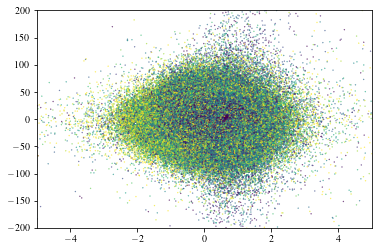

In [5]:
plt.scatter(deltaR[lowa], vr[lowa],c=data['MG_FE'][lowa],s=0.1,vmin=0., vmax=0.12)
plt.xlim(-5,5)
plt.ylim(-200,200)


# Start the modelling

In [6]:
Rg_l, Rg_r = (7., 9.)

Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)

oti_data = oti.OTIData(
    pos=z[Rg_mask&lowa_omask],
    vel=vz[Rg_mask&lowa_omask],
    labels=dict(mgfe=data['MG_FE'][Rg_mask&lowa_omask]),
    label_errs=dict(mgfe=data['MG_FE_ERR'][Rg_mask&lowa_omask]),
)
print(np.max(oti_data.vel))

max_z = 2 * np.nanpercentile(np.abs(oti_data.pos), 90)
max_vz = 2 * np.nanpercentile(np.abs(oti_data.vel), 90).to(u.km / u.s)
max_z, max_vz

0.07955937343178489 kpc / Myr


(<Quantity 1.81460102 kpc>, <Quantity 65.38808396 km / s>)

In [7]:
zbins = np.linspace(-1, 1, 101) * max_z
vzbins = np.linspace(-1, 1, 101) * max_vz
zvz_bins = {"pos": zbins, "vel": vzbins}

6.0 True 1621
6.25 True 2404
6.5 True 1948
6.75 True 2047
7.0 True 2592
7.25 True 3336
7.5 True 3476
7.75 True 3095
8.0 True 3716
8.25 True 3596
8.5 True 2424
8.75 True 2956
9.0 True 2740
9.25 True 2427
9.5 True 1979
9.75 True 1487
10.0 True 1460
10.25 True 1620
10.5 True 3246
10.75 True 2747
11.0 True 3182
11.25 True 3789
11.5 True 2600
11.75 True 2622
12.0 True 2501


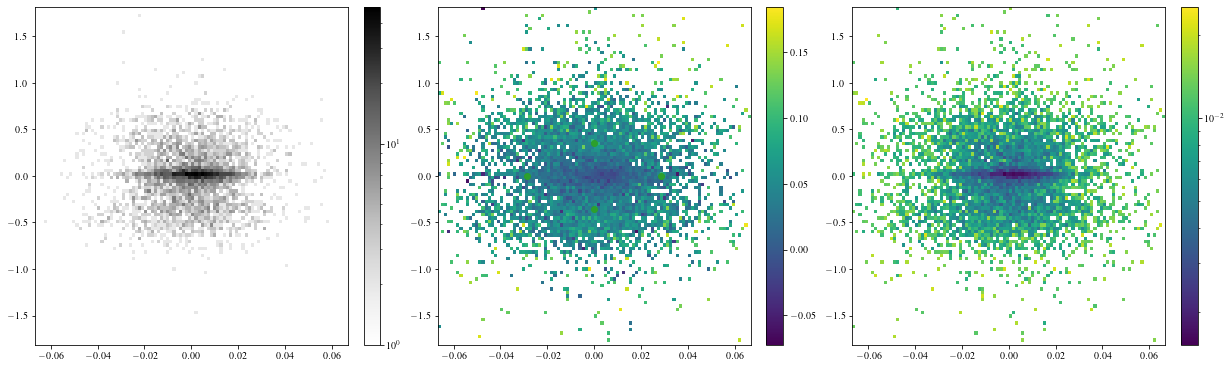

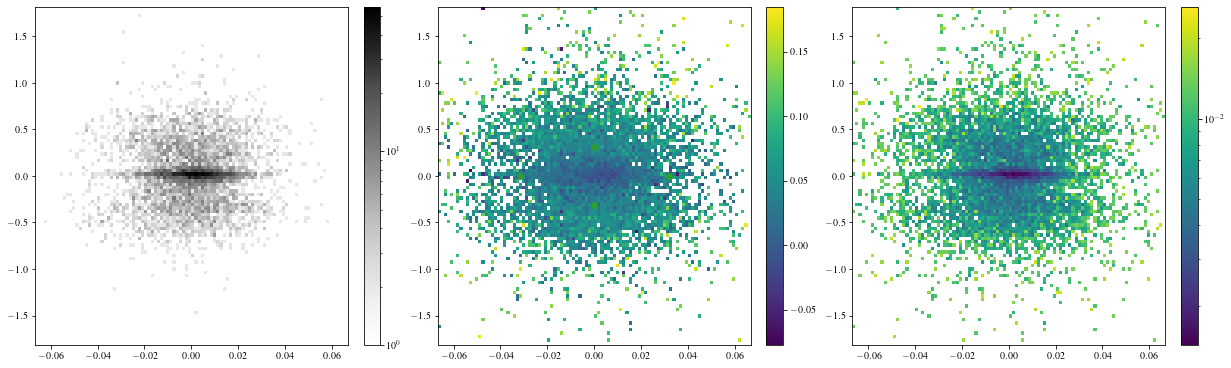

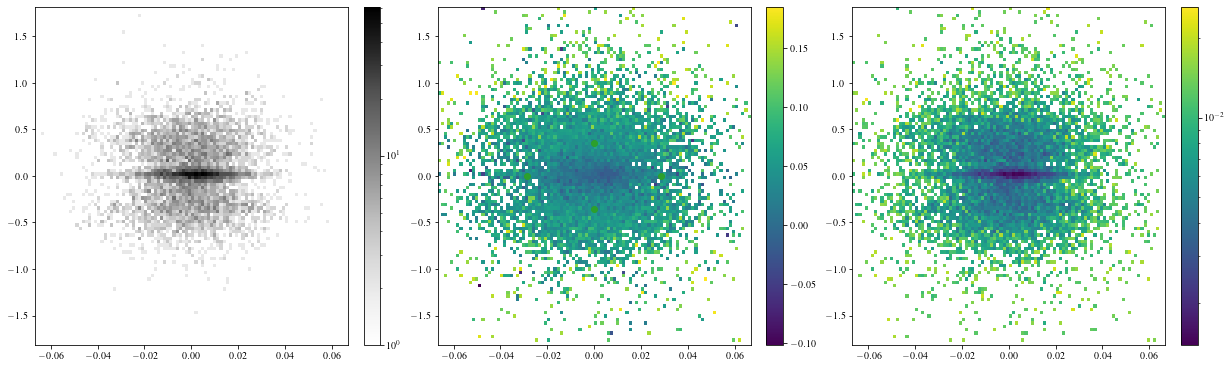

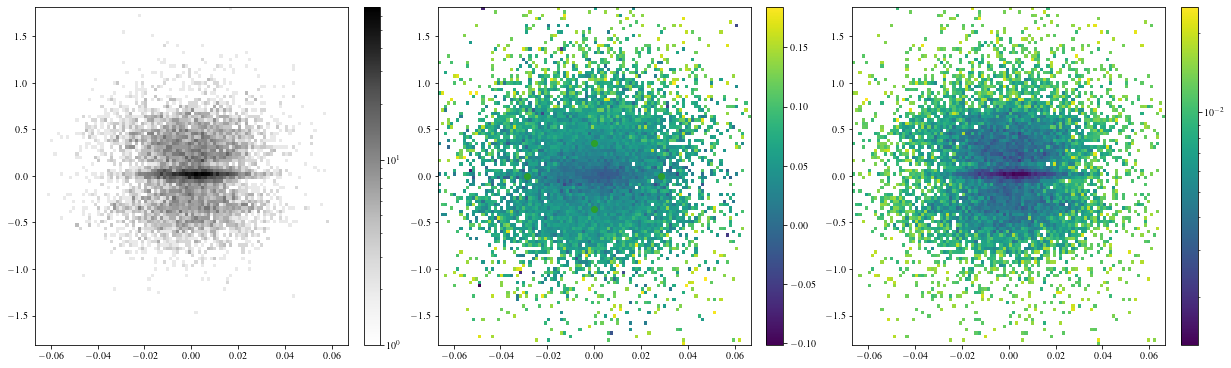

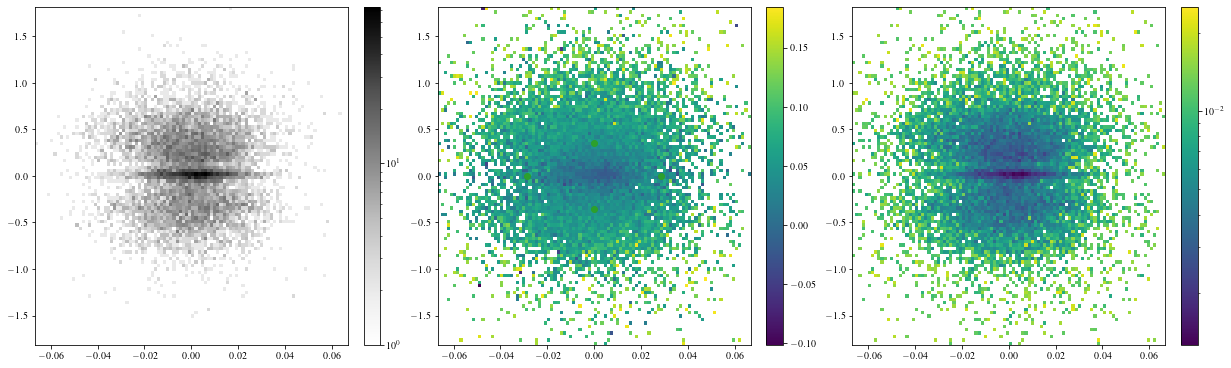

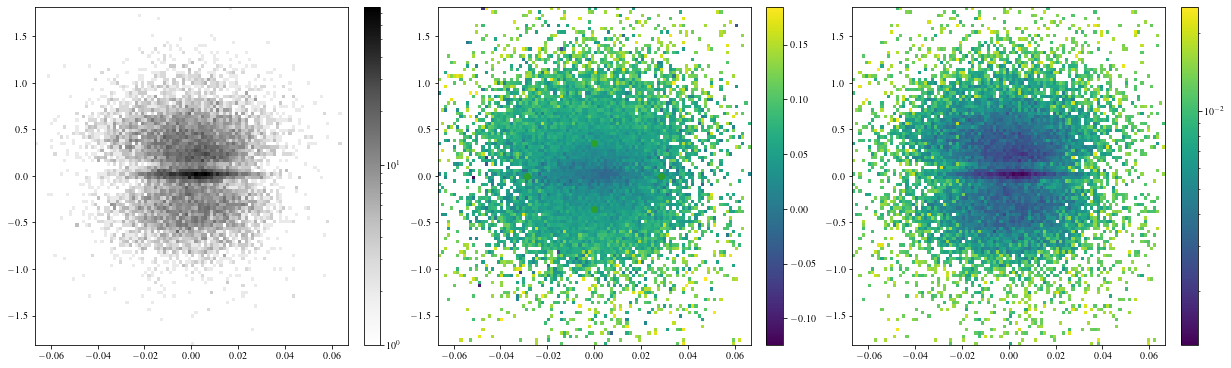

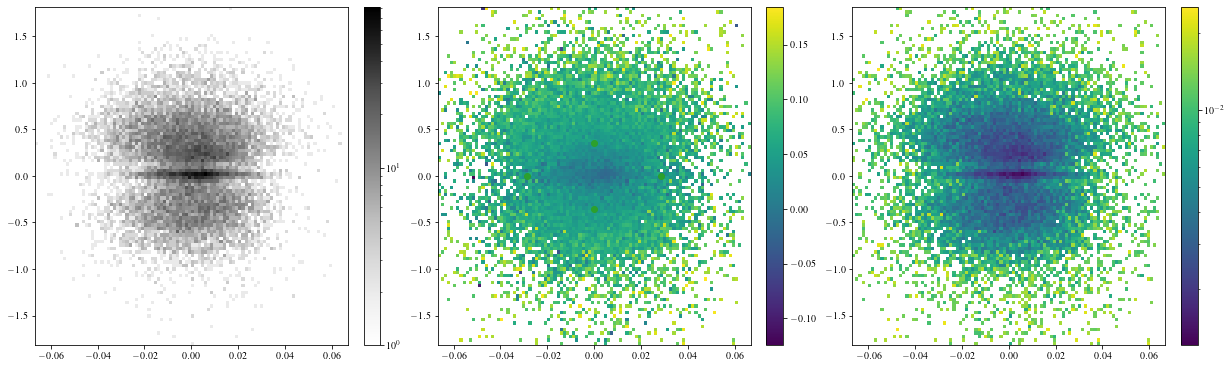

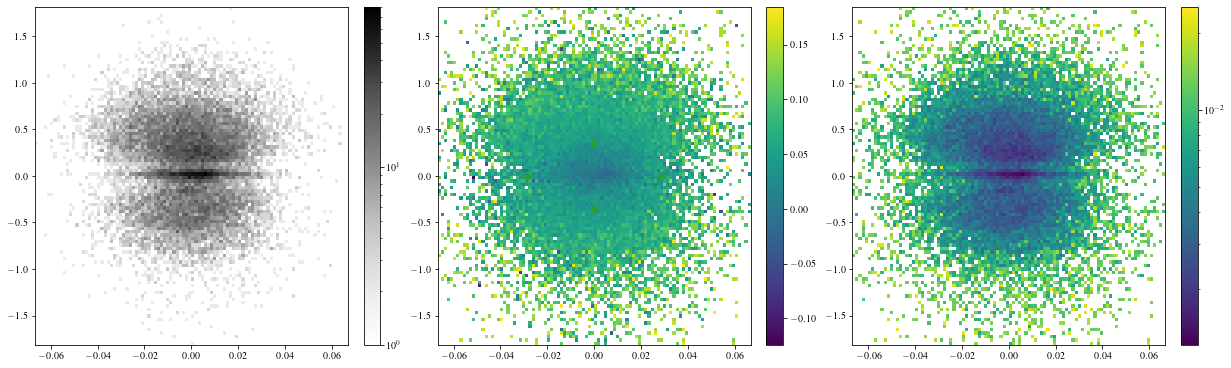

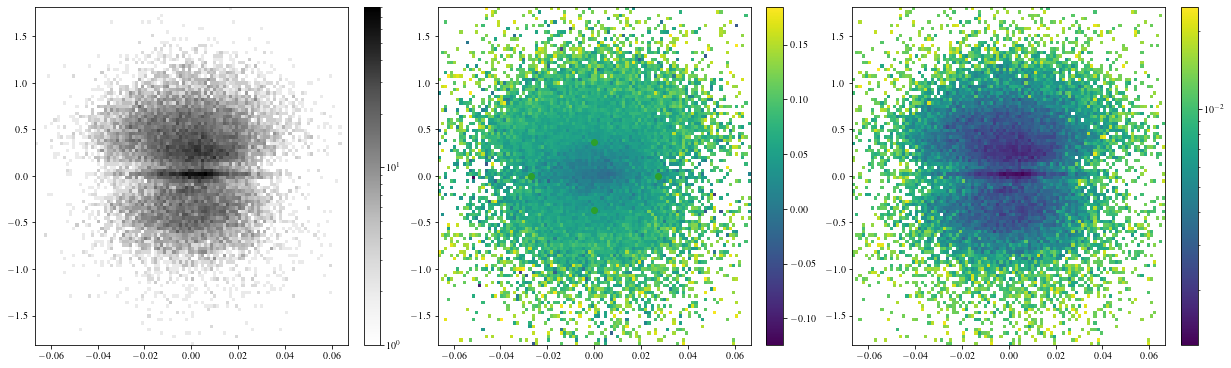

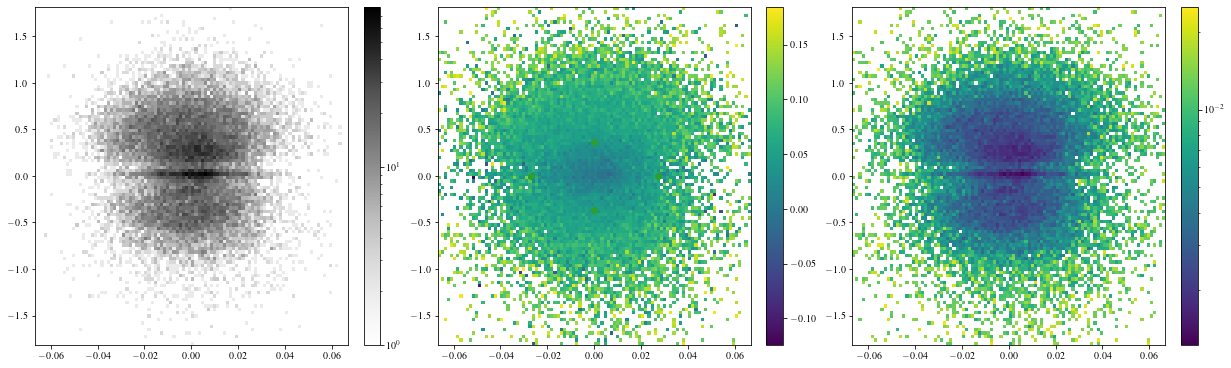

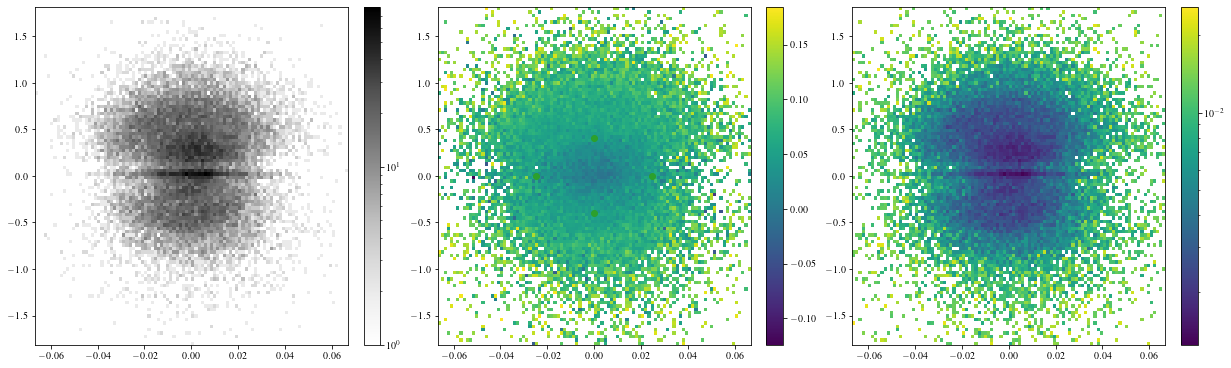

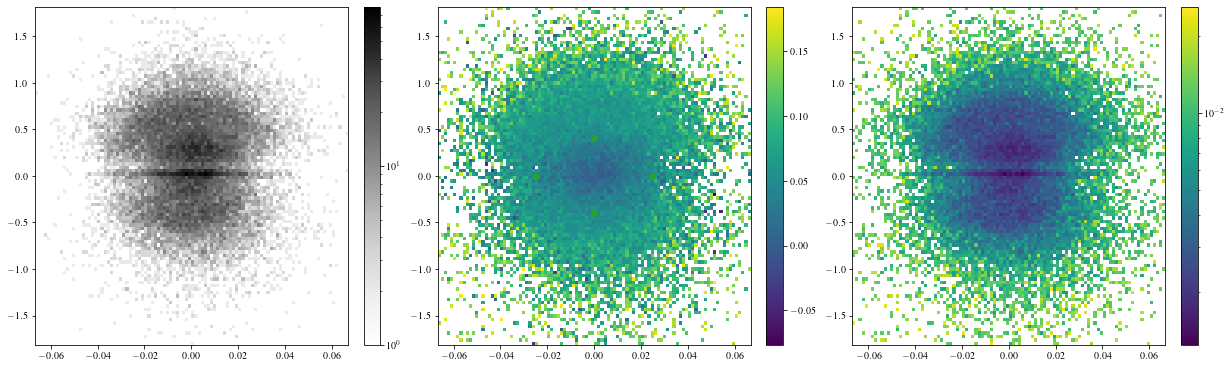

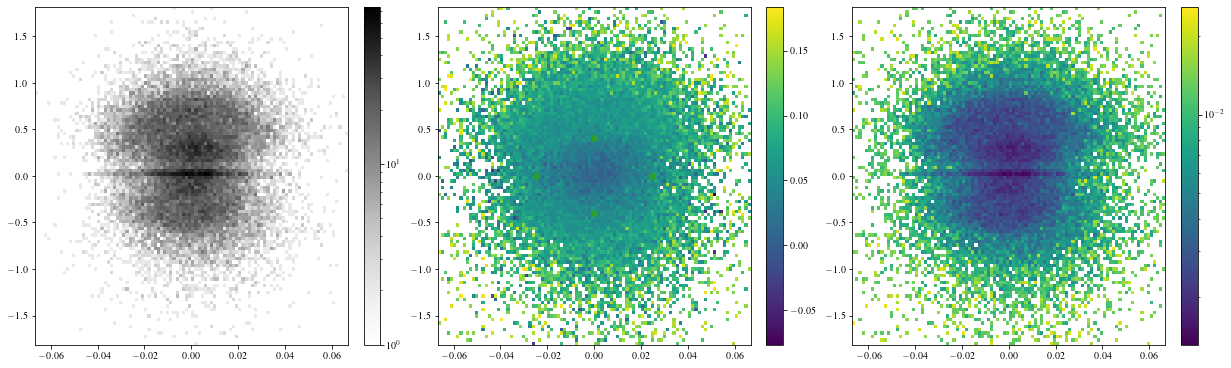

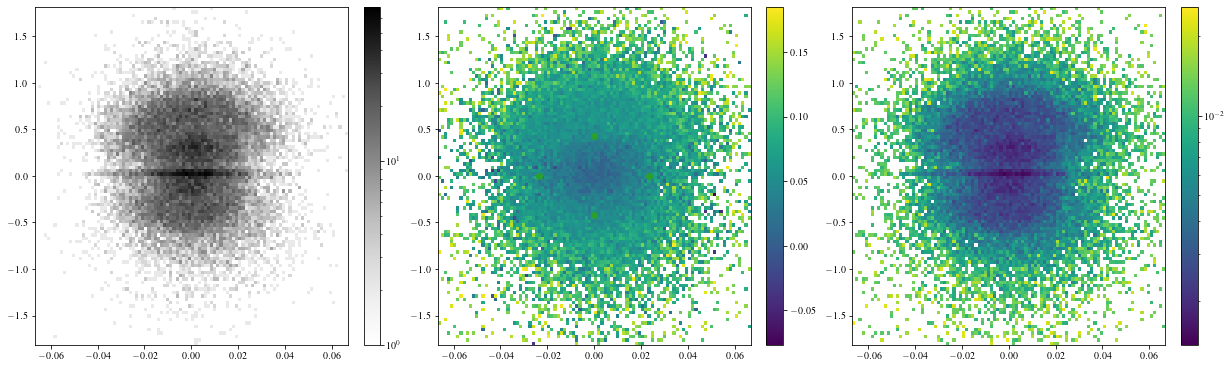

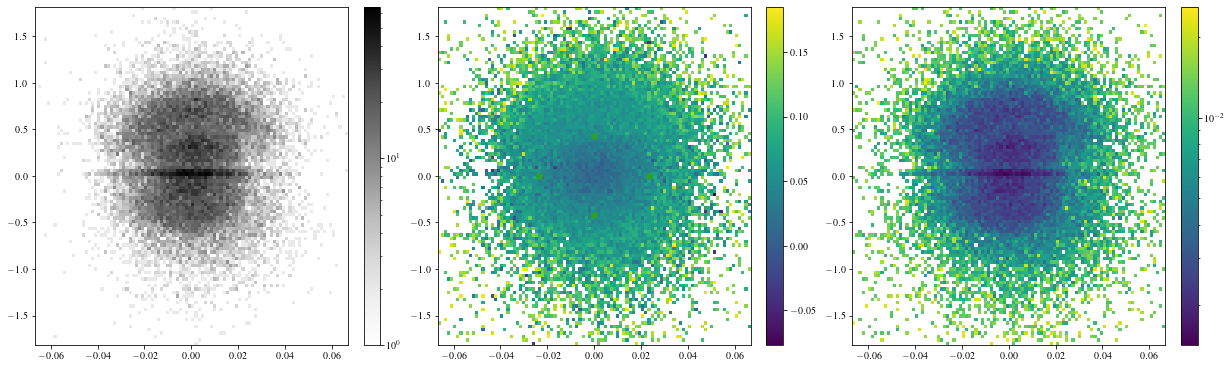

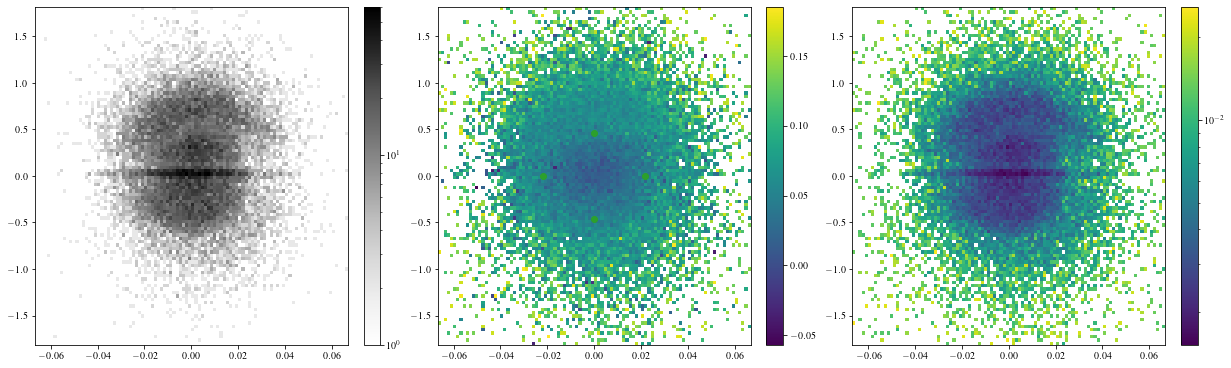

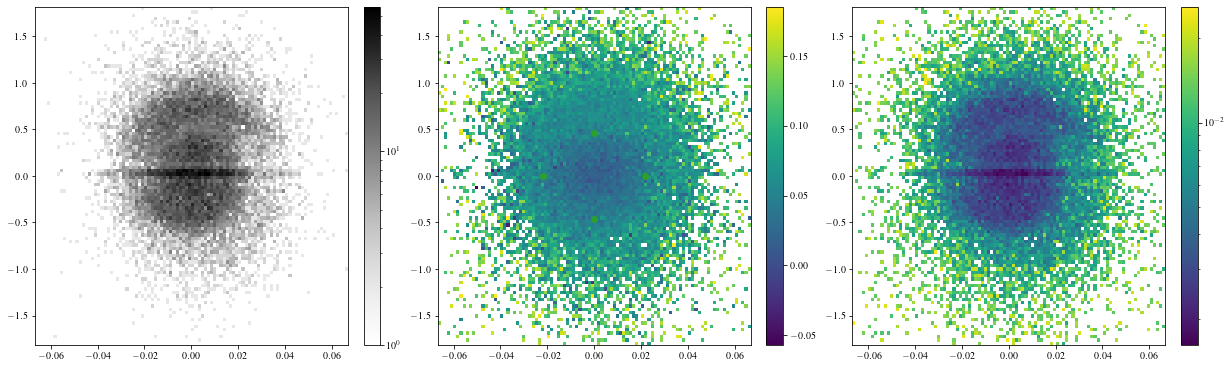

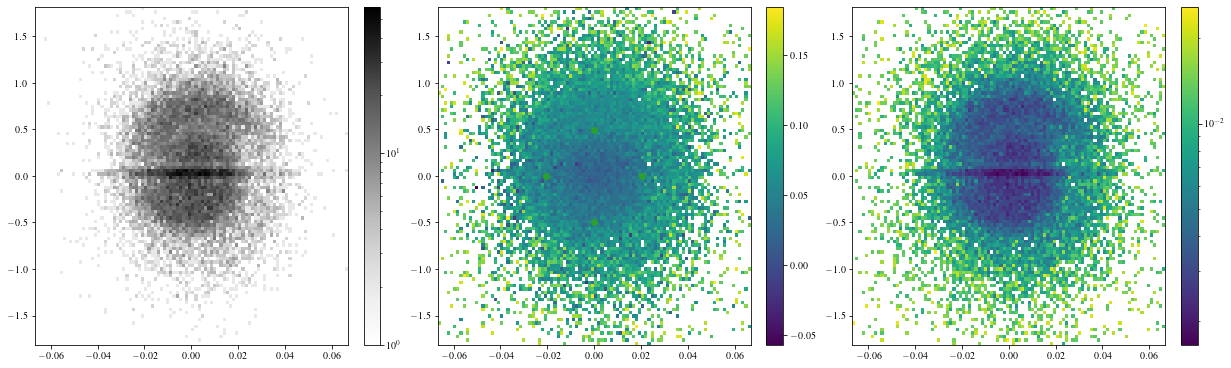

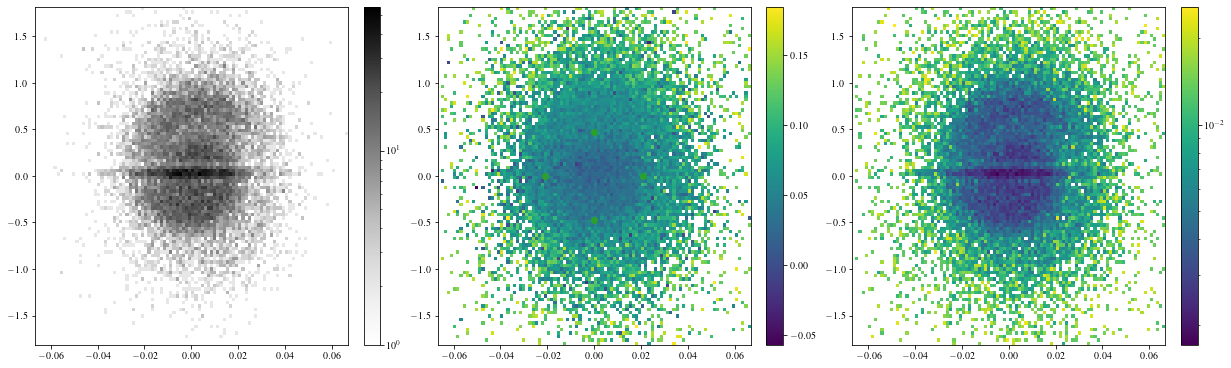

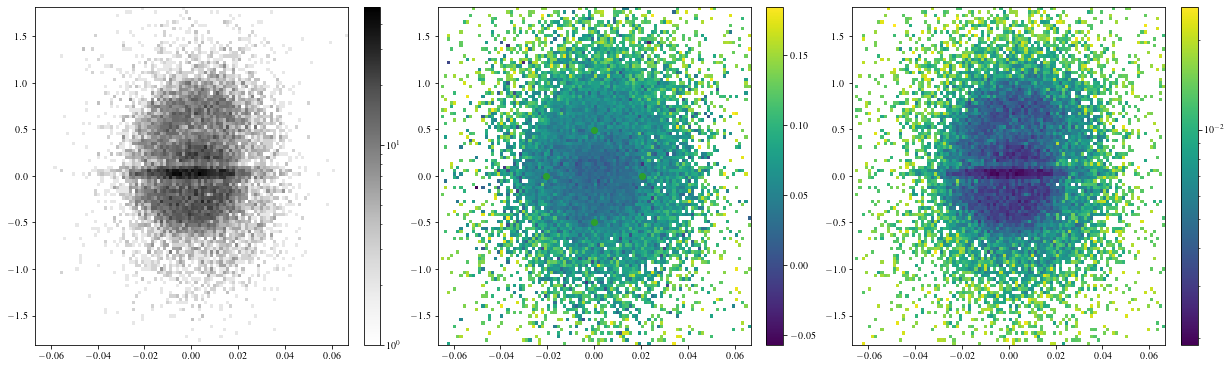

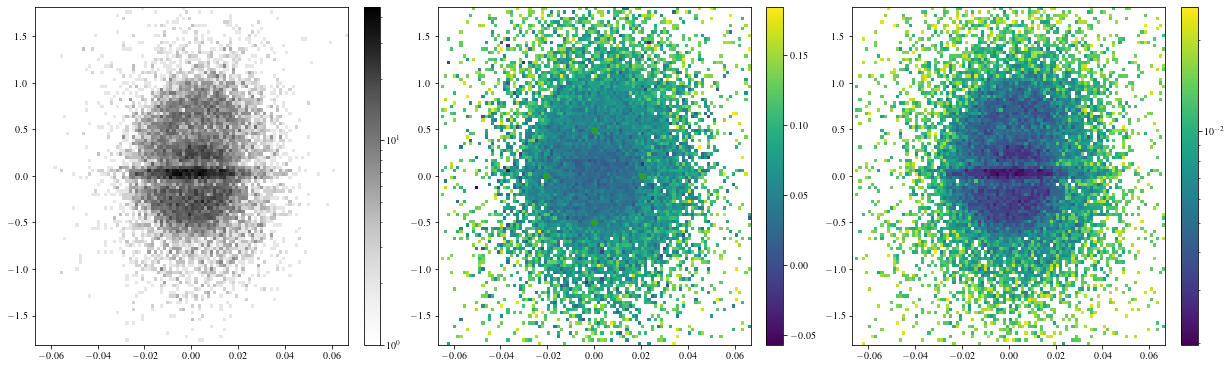

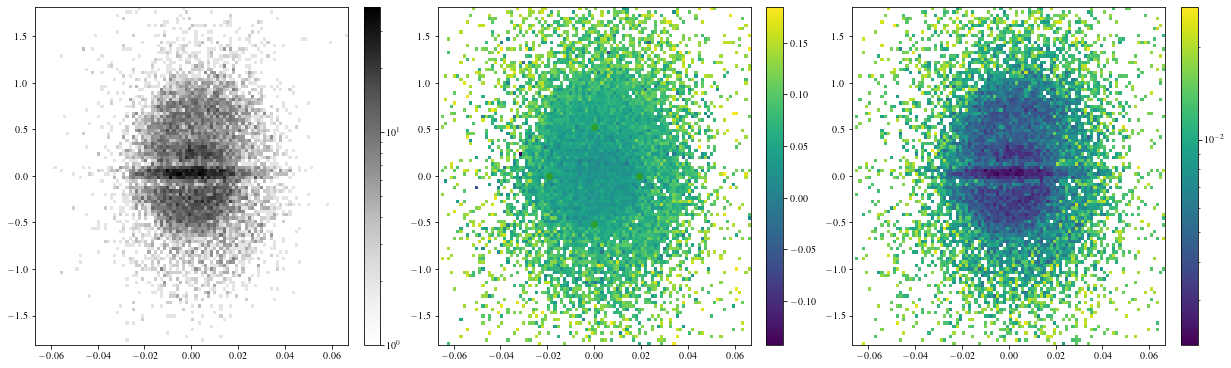

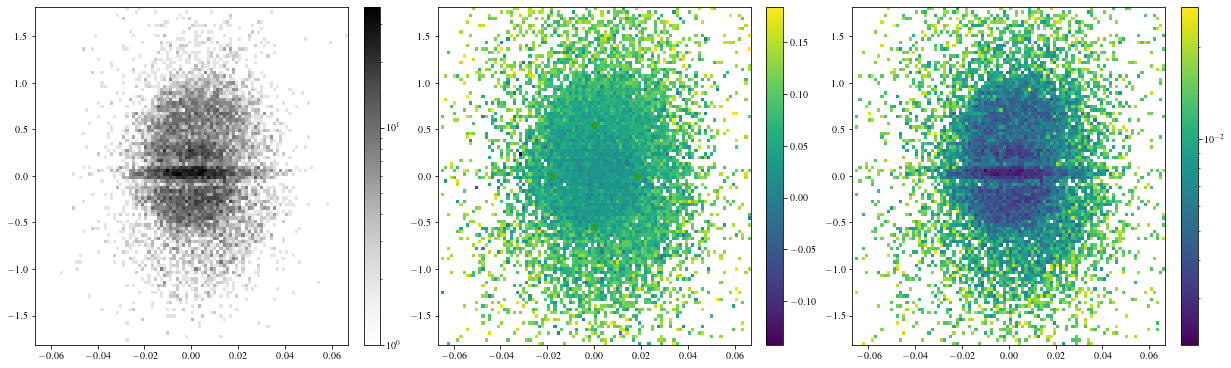

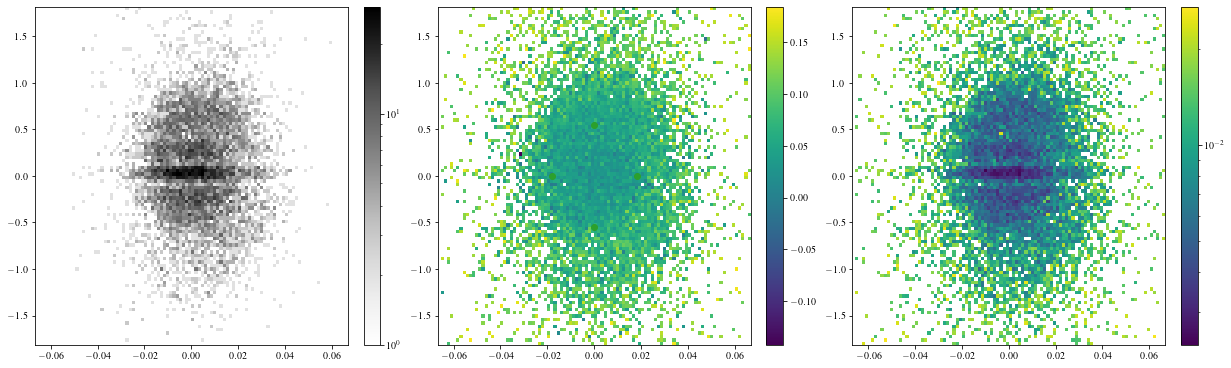

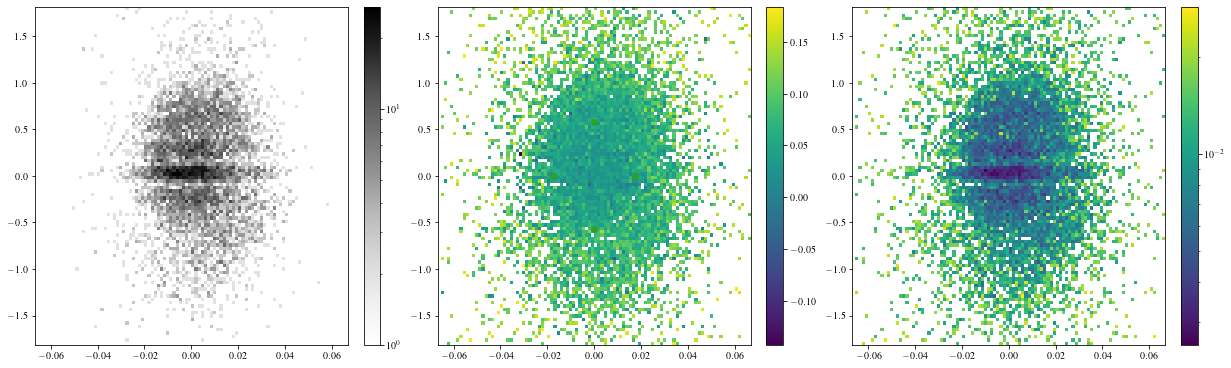

In [8]:
Rg_w = 2.
Rg_cs = np.arange(6, 12+1e-3, 0.25)

oti_datas = []
bdatas = []
reses = []

for Rg_c in Rg_cs:
    Rg_l, Rg_r = (Rg_c - Rg_w/2, Rg_c + Rg_w/2)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)

    oti_data = oti.OTIData(
        pos=z[Rg_mask&lowa_omask],
        vel=vz[Rg_mask&lowa_omask],
        labels=dict(mgfe=data['MG_FE'][Rg_mask&lowa_omask]),
        label_errs=dict(mgfe=data['MG_FE_ERR'][Rg_mask&lowa_omask]),
    )
    oti_datas.append(oti_data)
        
    cdata = oti_data.get_binned_counts(zvz_bins)
    bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
    bdatas.append(bdata)
    
    std_im = bdata['mgfe_err'] * np.sqrt(cdata['counts'])
    std_im[cdata['counts'] < 10] = np.nan

    ell_mask = np.abs(bdata['mgfe'] - np.nanpercentile(oti_data.labels['mgfe'], 15)) < 3 * np.nanmean(std_im)
    tmpv = bdata['vel'][ell_mask]
    tmpz = bdata['pos'][ell_mask]
    init_Omega = MAD(tmpv) / MAD(tmpz) * u.rad
    
    # ---
    
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    cs = axes[0].pcolormesh(
        bdata["vel"].value,
        bdata["pos"].value,
        cdata["counts"],
        norm=mpl.colors.LogNorm(),
        cmap="Greys",
    )
    fig.colorbar(cs, ax=axes[0])

    cs = axes[1].pcolormesh(
        bdata["vel"].value,
        bdata["pos"].value,
        bdata["mgfe"],
    )
    fig.colorbar(cs, ax=axes[1])

    for ss in [1, -1]:
        axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
        axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs = axes[2].pcolormesh(
        bdata["vel"].value, bdata["pos"].value, bdata["mgfe_err"], norm=mpl.colors.LogNorm()
    )
    fig.colorbar(cs, ax=axes[2])
    
    max_re = np.mean(
        [
            (max_z * np.sqrt(init_Omega)).decompose(galactic).value,
            (max_vz / np.sqrt(init_Omega)).decompose(galactic).value,
        ]
    )
    
    model = SplineLabelModelWrapper(
        r_e_max=max_re,
        label_n_knots=9,
        label0_bounds=(-1.0, 1.0),
        label_grad_sign=1.0,
        label_regularize_sigma=1.0,
        label_smooth_sigma=0.2,
        e_n_knots={2: 8, 4: 4},
        e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
        e_regularize_sigmas={2: 0.1, 4: 0.1},
        e_smooth_sigmas={2: 0.2, 4: 0.2},
    )
    
    p0 = model.get_init_params(oti_data)
    p0["e_params"][2]["vals"] = np.full_like(p0["e_params"][2]["vals"], -0.25)
    p0["e_params"][4]["vals"] = np.full_like(p0["e_params"][4]["vals"], np.log(0.1 / max_re))    
    
    bdata, res = model.run(
        bdata,
        p0=p0,
        label_name="mgfe",
        bins=zvz_bins,
        jaxopt_kw=dict(maxiter=32768, tol=1e-10)
    )
    print(Rg_c, res.state.success, res.state.iter_num)
    reses.append(res)

In [9]:
import tqdm
pcls = []
for bdata, res in tqdm.tqdm_notebook(zip(bdatas, reses)):
    tmp_data = bdata.copy()
    tmp_data["label"] = tmp_data.pop("mgfe")
    tmp_data["label_err"] = tmp_data.pop("mgfe_err")
    tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
    tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

    errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
    
    Omega0_samples = np.exp(np.random.normal(res.params['ln_Omega0'], errs['ln_Omega0'][0], size=100)) / u.Myr
    rho0_samples = (Omega0_samples**2 / (4*np.pi * G)).to_value(u.Msun/u.pc**3)
    
    pcls.append(np.nanpercentile(rho0_samples, [5, 16, 50, 84, 95]))
    
pcls = np.array(pcls)

0it [00:00, ?it/s]

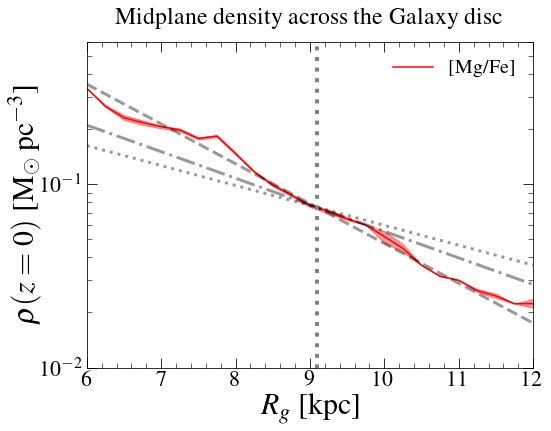

In [10]:
rads = np.linspace(6,12,13)
norm = 0.075 # normalised to the Rg of the Sun??
ys = norm*np.exp(-(rads-9.09)/2)
ys2 = norm*np.exp(-(rads-9.09)/3)
ys3 = norm*np.exp(-(rads-9.09)/4)

fig = plt.figure(figsize=(8,6),facecolor='white')

fig.suptitle('Midplane density across the Galaxy disc',fontsize=24,x=0.51,y=.96)

plt.plot(Rg_cs, pcls[:,2],label='[Mg/Fe]',color='r')
plt.fill_between(Rg_cs, pcls[:,1], pcls[:,-2], zorder=-10, color='r',alpha=0.4)
plt.legend(loc='upper right',fontsize=20)
plt.yscale('log')
plt.plot(rads,ys,color='k',ls='--',lw=3,alpha=0.4)
plt.plot(rads,ys2,color='k',ls='-.',lw=3,alpha=0.4)
plt.plot(rads,ys3,color='k',ls='dotted',lw=3,alpha=0.4)
plt.xlim(6,12)
plt.vlines(9.09,0,0.6,color='gray',lw=4,ls='dotted')
plt.legend(loc='upper right',frameon=False,ncol=3,fontsize=20)
plt.ylim(0.01,0.6)
plt.ylabel(r'$\rho(z=0)$ [M$_{\odot}$ pc$^{-3}$]',fontsize=30,labelpad=0.1)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/rho0_mg-resub.pdf',dpi=400, bbox_inches = 'tight')


In [11]:
# np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/pcls-100boots',np.array(pcls))
# np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/errs-100boots',np.array(errs))


# Now do the same bootstrapping

In [8]:
# we will bootstrap 10 times for now to speed things up
def create_boot_samp(z,vz,xfe,xfe_err,bins,n=50):
    zs_boot = []
    vzs_boot = []
    xfe_boot = []
    xfe_err_boot = []
    
    #loop over bins
    for indx, i in enumerate(bins):
        # create the bootstrap samples  
        # in order to sample the distribution using bootstrap with resampling and to get the correct
        # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
        # otherwise you get incorrect fehs for every abundance
        random_ids = np.arange(len(z[i]))
        
        samples_indices = bootstrap(random_ids, n).astype(int)
        # within a bin, loop over all the 
        zs_bo = []
        vzs_bo = []
        xfe_bo = []
        xfe_err_bo = []
        for jndx, j in enumerate(samples_indices):
            # find the stars with the correct id
            zs_b = z[i][j]
            zs_bo.append(zs_b)
            vzs_b = vz[i][j]
            vzs_bo.append(vzs_b)
            xfe_b = xfe[i][j]
            xfe_bo.append(xfe_b)
            xfe_err_b = xfe_err[i][j]
            xfe_err_bo.append(xfe_err_b)
            
        zs_boot.append(zs_bo)
        vzs_boot.append(vzs_bo)
        xfe_boot.append(xfe_bo)
        xfe_err_boot.append(xfe_err_bo)
            
    return zs_boot, vzs_boot, xfe_boot,xfe_err_boot


In [9]:
Rg_w = 2.
Rg_cs = np.arange(6, 12.+1e-3, 0.25)
deltaR = (Rg_cs[1]-Rg_cs[0])

bins = []
for Rg_c in Rg_cs:
    Rg_l, Rg_r = (Rg_c - Rg_w/2, Rg_c + Rg_w/2)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r) & lowa_omask 
    bins.append(Rg_mask)

In [10]:
zs_boot, vzs_boot, xfe_boot, xfe_err_boot = create_boot_samp(z,vz,data['MG_FE'],data['MG_FE_ERR'],bins,n=25)


In [15]:
Rg_w = 2.
Rg_cs = np.arange(6, 12+1e-3, 0.25)

oti_datas_boot = []
bdatas_boot = []
reses_boot = []

for indx, i in tqdm.tqdm_notebook(enumerate(zs_boot)):
    for jndx, j in enumerate(i):

        oti_data = oti.OTIData(
            pos=j,
            vel=vzs_boot[indx][jndx],
            labels=dict(mgfe=xfe_boot[indx][jndx]),
            label_errs=dict(mgfe=xfe_err_boot[indx][jndx]),
        )
        oti_datas_boot.append(oti_data)

        cdata = oti_data.get_binned_counts(zvz_bins)
        bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
        bdatas_boot.append(bdata)

        std_im = bdata['mgfe_err'] * np.sqrt(cdata['counts'])
        std_im[cdata['counts'] < 10] = np.nan

        ell_mask = np.abs(bdata['mgfe'] - np.nanpercentile(oti_data.labels['mgfe'], 15)) < 3 * np.nanmean(std_im)
        tmpv = bdata['vel'][ell_mask]
        tmpz = bdata['pos'][ell_mask]
        init_Omega = MAD(tmpv) / MAD(tmpz) * u.rad

        max_re = np.mean(
            [
                (max_z * np.sqrt(init_Omega)).decompose(galactic).value,
                (max_vz / np.sqrt(init_Omega)).decompose(galactic).value,
            ]
        )

        model = SplineLabelModelWrapper(
            r_e_max=max_re,
            label_n_knots=9,
            label0_bounds=(-1.0, 1.0),
            label_grad_sign=1.0,
            label_regularize_sigma=1.0,
            label_smooth_sigma=0.2,
            e_n_knots={2: 8, 4: 4},
            e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
            e_regularize_sigmas={2: 0.1, 4: 0.1},
            e_smooth_sigmas={2: 0.2, 4: 0.2},
        )

        p0 = model.get_init_params(oti_data)
        p0["e_params"][2]["vals"] = np.full_like(p0["e_params"][2]["vals"], -0.25)
        p0["e_params"][4]["vals"] = np.full_like(p0["e_params"][4]["vals"], np.log(0.1 / max_re))
        
        bdata, res = model.run(
            bdata,
            p0=p0,
            label_name="mgfe",
            bins=zvz_bins,
            jaxopt_kw=dict(maxiter=32768, tol=1e-10)
        )
        reses_boot.append(res)
        

0it [00:00, ?it/s]

In [19]:
# save the values
import pickle

with open('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/reses-boot-resubmit.pickle', 'wb') as handle:
    pickle.dump(reses_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/oti-datas-boot-resubmit.pickle', 'wb') as handle:
    pickle.dump(oti_datas_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/bdatas-boot-resubmit',np.array(bdatas_boot))


# Compute $a_z$ and $\Sigma(z)$

Already computed these

In [11]:
pos_grid = np.linspace(0, 1.2, 25) * u.kpc

In [12]:
Sigz_2d = []
az_2d = []
for res in enumerate(reses_boot):
    az = model.label_model.get_acceleration(pos_grid, res[1].params)
    az_2d.append(az)

    Sigz = (np.abs(az) / (2*np.pi*G)).to_value(u.Msun / u.pc**2)
    Sigz_2d.append(Sigz)
    

NameError: name 'reses_boot' is not defined

In [13]:
azs = np.reshape(az_2d,(25,25,25))
sigmas = np.reshape(Sigz_2d,(25,25,25))


ValueError: cannot reshape array of size 0 into shape (25,25,25)

In [14]:
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/azs-resubmit',np.array(azs))
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/sigmas-resubmit',np.array(sigmas))


NameError: name 'azs' is not defined

In [15]:
azs_2d = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/azs-resubmit-1.2kpc.npy',allow_pickle=True)
sigmas_2d = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/sigmas-resubmit-1.2kpc.npy',allow_pickle=True)


In [16]:
azs_2d = (azs*(u.kpc/u.Myr**2)).to(u.km/(u.Myr*u.s))

NameError: name 'azs' is not defined

In [35]:
sigmas_perce = np.percentile(sigmas,[16,50,84],axis=1)
sigmas_perce =sigmas_perce*u.Msun/u.pc**2


In [36]:
sigmas_plot_median = np.array(sigmas_perce[1,::4])
sigmas_plot_low = np.array(sigmas_perce[0,::4])
sigmas_plot_high = np.array(sigmas_perce[2,::4])
Rg_plot = Rg_cs[::4]

In [37]:
import gala.potential as gp
from astropy.constants import G
import astropy.units as u
from scipy.integrate import simpson

potential = gp.MilkyWayPotential2022()

Rgs_gala = np.arange(6., 12.+1e-3, 1.)
zs_gala = np.linspace(0, 1.2, 25) * u.kpc

xyz = np.zeros((3, ) + (Rgs_gala.size,) + (zs_gala.size,))
xyz[0] = Rgs_gala[:, None]
xyz[2] = zs_gala[None]

azs_gala = potential.acceleration(xyz)[2]
dens_gala = potential.density(xyz).reshape(xyz.shape[1:]).to(u.Msun/u.pc**3)
Kz_Sigmazs_gala = (-azs_gala / (2*np.pi*G)).to(u.Msun/u.pc**2)

Sigmazs_gala = np.zeros((Rgs_gala.size, zs_gala.size-1))
for i in range(1, zs_gala.size):
    Sigmazs_gala[:, i-1] = 2 * simpson(dens_gala[:, :i], 1e3 * zs_gala[None, :i], axis=-1)


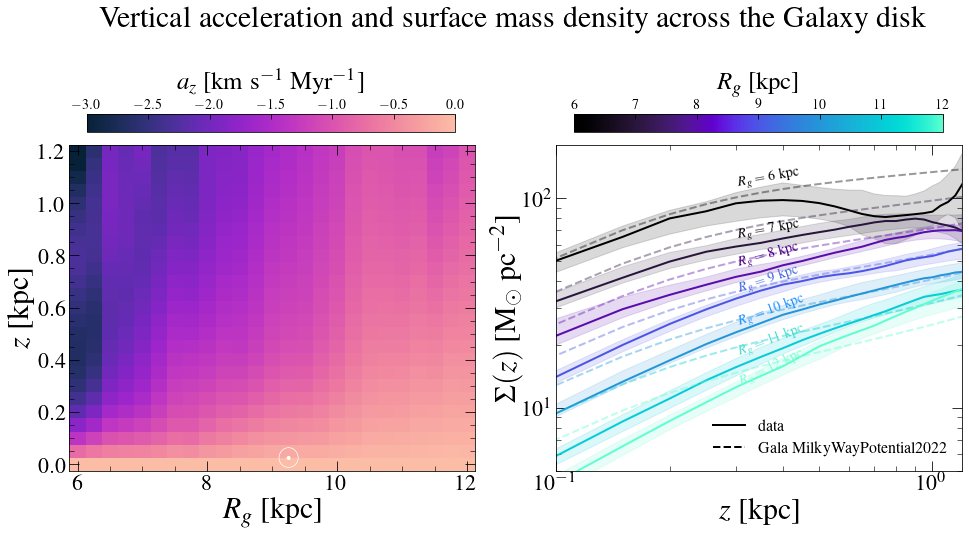

In [72]:
import cmasher
fig = plt.figure(figsize=(16,6),facecolor='white', rasterized=True)

fig.suptitle('Vertical acceleration and surface mass density across the Galaxy disk',fontsize=30,x=0.51,y=1.2,rasterized=True)

plt.subplot(1,2,1)

plt.pcolormesh(
    Rg_cs,
    pos_grid.value,
    np.nanmean(azs_2d,axis=1).T,
    shading="auto",
    cmap=cm.bubblegum,
    vmin=-3.,
    vmax=0,
)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.ylabel(r'$z$ [kpc]',fontsize=30)
# plt.colorbar(label=r'$K_{z}$ [kpc Myr$^{-2}$]')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.xlim(6,12)
# plt.ylim(0,1.3)
plt.text(9.09,0.0,r'$\odot$',color='white',fontsize=30,weight="bold")
cbar_ax = fig.add_axes([0.14, 0.91, 0.32,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$a_{z}$ [km s$^{-1}$ Myr$^{-1}$]',fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=30)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)


plt.subplot(1,2,2)

sm = plt.cm.ScalarMappable(cmap=cmasher.cosmic, norm=plt.Normalize(vmin=Rg_plot[0],vmax=Rg_plot[-1]))
norm = plt.Normalize()
colours = cmasher.cosmic(norm(Rg_plot))
for indx, i in enumerate(sigmas_plot_median):
    plt.plot(np.array(pos_grid),i,color=colours[indx],lw=2)
    plt.fill_between(np.array(pos_grid),sigmas_plot_low[indx],sigmas_plot_high[indx],color=colours[indx],alpha=0.15)
    plt.plot(zs_gala,Kz_Sigmazs_gala[indx],color=colours[indx],lw=2,ls='dashed',alpha=0.4)
#     plt.xlim(0.1,1.3)
#     plt.ylim(0,150)
    plt.ylabel(r'$\Sigma(z)$ [M$_{\odot}$ pc$^{-2}$]',fontsize=30,labelpad=0.1)
    plt.xlabel(r'$z$ [kpc]',fontsize=30)
    plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
    plt.minorticks_on()
plt.plot([-4,-2],[0,1],lw=2,label='data',color='k')
plt.plot([-4,-2],[0,1],lw=2,label='Gala MilkyWayPotential2022',color='k',ls='dashed')
plt.legend(loc='lower right',fontsize=16,frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5,180)
plt.xlim(0.1,1.2)
plt.text(0.3,115,'$R_g=6~\mathrm{kpc}$',fontsize=14,color='k',rotation=10)
plt.text(0.3,65,'$R_g=7~\mathrm{kpc}$',fontsize=14,color='k',rotation=10)
plt.text(0.3,48,'$R_g=8~\mathrm{kpc}$',fontsize=14,color='indigo',rotation=15)
plt.text(0.3,36,'$R_g=9~\mathrm{kpc}$',fontsize=14,color='royalblue',rotation=18)
plt.text(0.3,25,'$R_g=10~\mathrm{kpc}$',fontsize=14,color='dodgerblue',rotation=20)
plt.text(0.3,18,'$R_g=11~\mathrm{kpc}$',fontsize=14,color='turquoise',rotation=20)
plt.text(0.3,13,'$R_g=12~\mathrm{kpc}$',fontsize=14,color='aquamarine',rotation=25)

cbar_ax = fig.add_axes([0.563, 0.91, 0.32,0.04])
cb = plt.colorbar(sm,cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$R_{g}$ [kpc]',fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=30)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)


plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/force-law-sigma-Mg-resubmit.pdf',dpi=500, bbox_inches = 'tight')


In [48]:
import tqdm
pcls = []
rhos = []
for bdata, res in tqdm.tqdm_notebook(zip(bdatas_boot, reses_boot)):
    tmp_data = bdata.copy()
    tmp_data["label"] = tmp_data.pop("mgfe")
    tmp_data["label_err"] = tmp_data.pop("mgfe_err")
    tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
    tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}
    
#     Omega0_samples = np.exp(np.random.normal(res.params['ln_Omega0'], errs['ln_Omega0'][0], size=1)) / u.Myr
    Omega0_samples = np.exp(res.params['ln_Omega0']) / u.Myr
    rho0_samples = (Omega0_samples**2 / (4*np.pi * G)).to_value(u.Msun/u.pc**3)
    rhos.append(rho0_samples)
    pcls.append(np.nanpercentile(rho0_samples, [5, 16, 50, 84, 95]))
    
pcls = np.array(pcls)

0it [00:00, ?it/s]

In [49]:
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/rhos_percentiles-resubmit',np.array(pcls))
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/rhos_samples-resubmit',np.array(rhos))


In [50]:
# rhos = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/rhos_samples-resubmit.npy',allow_pickle=True)


In [51]:
rho_ = np.reshape(rhos,(25,25))
rho_pcl = np.percentile(rho_,[5,16,50,84,95],axis=1)
print(np.shape(rho_pcl))

(5, 25)


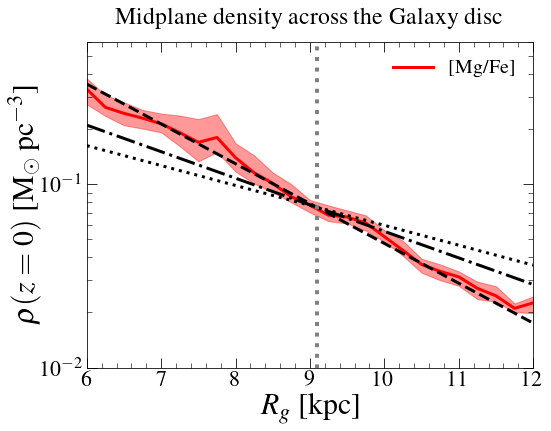

In [52]:
rads = np.linspace(6,12,13)
norm = 0.075 #normalised to the Rg of the Sun??
ys = norm*np.exp(-(rads-9.09)/2)
ys2 = norm*np.exp(-(rads-9.09)/3)
ys3 = norm*np.exp(-(rads-9.09)/4)

fig = plt.figure(figsize=(8,6),facecolor='white')

fig.suptitle('Midplane density across the Galaxy disc',fontsize=24,x=0.51,y=.96)

plt.plot(Rg_cs, rho_pcl[2,:],label='[Mg/Fe]',color='r',lw=3)
plt.fill_between(Rg_cs, rho_pcl[1,:], rho_pcl[-2,:], zorder=-10, color='r',alpha=0.4)
plt.legend(loc='upper right',fontsize=20)
plt.yscale('log')
plt.plot(rads,ys,color='k',ls='--',lw=3)
plt.plot(rads,ys2,color='k',ls='-.',lw=3)
plt.plot(rads,ys3,color='k',ls='dotted',lw=3)
plt.xlim(6,12)
plt.vlines(9.09,0,0.6,color='gray',lw=4,ls='dotted')
plt.legend(loc='upper right',frameon=False,ncol=3,fontsize=20)
plt.ylim(0.01,0.6)
plt.ylabel(r'$\rho(z=0)$ [M$_{\odot}$ pc$^{-3}$]',fontsize=30,labelpad=0.1)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/rho0_mg-resubmit.pdf',dpi=500, bbox_inches = 'tight')


# Let's fit this relation to optimise $h_R$ and $\rho(z=0)_{\odot}$

In [53]:
from scipy.optimize import curve_fit
def exp(xs,norm, scalerad):
    return norm*np.exp(-(xs-9.09)/scalerad)


In [54]:
popt, pcov = curve_fit(exp, Rg_cs, rho_pcl[2,:])
popt_l, pcov_l = curve_fit(exp, Rg_cs, rho_pcl[1,:])
popt_h, pcov_h = curve_fit(exp, Rg_cs, rho_pcl[3,:])
print(popt-popt_l,popt,popt_h-popt)

[ 0.00942252 -0.05946553] [0.0806274  2.24208692] [0.01547573 0.03985   ]


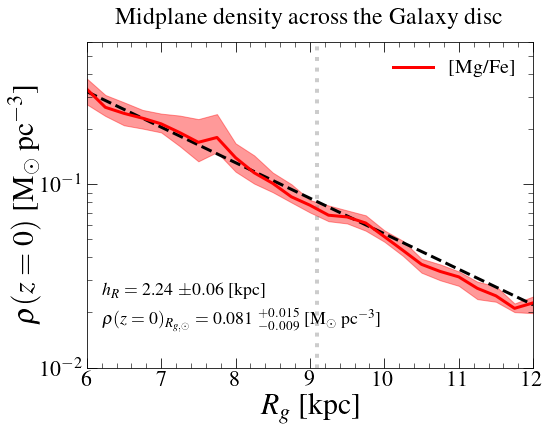

In [57]:
rads = np.linspace(6,12,128)
# norm = 0.075 #normalised to the Rg of the Sun??
ys = popt[0]*np.exp(-(rads-9.09)/popt[1])

fig = plt.figure(figsize=(8,6),facecolor='white')

fig.suptitle('Midplane density across the Galaxy disc',fontsize=24,x=0.51,y=.96)

plt.vlines(9.09,0,0.6,color='gray',lw=4,ls='dotted',alpha=0.4)
plt.plot(rads,ys,color='k',ls='--',lw=3)
plt.plot(Rg_cs, np.array(rho_pcl[2,:]),label='[Mg/Fe]',color='r',lw=3)
plt.fill_between(Rg_cs, np.array(rho_pcl[1,:]), np.array(rho_pcl[-2,:]), zorder=-10, color='r',alpha=0.4)
plt.legend(loc='upper right',fontsize=20)
plt.yscale('log')
plt.text(6.2,0.025,r'$h_R =$ '+str(round(popt[1],2))+r' $\pm 0.06$ [kpc]',fontsize=18)
plt.text(6.2,0.017,r'$\rho(z=0)_{R_{g,\odot}} =$ '+str(round(popt[0],3))+r' $^{+0.015}_{-0.009}$ [M$_{\odot}$ pc$^{-3}$]',fontsize=18)
plt.xlim(6,12)
plt.legend(loc='upper right',frameon=False,ncol=3,fontsize=20)
plt.ylim(0.01,0.6)
plt.ylabel(r'$\rho(z=0)$ [M$_{\odot}$ pc$^{-3}$]',fontsize=30,labelpad=0.1)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/rho0_mg-resubmit-fit.pdf',dpi=500, bbox_inches = 'tight')


In [58]:
grav = G.to(u.kpc**3/(u.Msun*u.Myr**2))
grav
def az(xs,hz):
    z=1.1
    grav = G.to(u.kpc**3/(u.Msun*u.Myr**2))
    gravs = np.array(grav)
    return -4*np.pi*gravs*xs*hz*np.tanh(z/hz)


In [59]:
azs_perce = np.percentile(azs,[16,50,84],axis=1)
azs_11 = azs_perce[1,:,-3]


In [60]:
rho_pcl = rho_pcl*u.Msun/u.pc**3
rho_pcl2 = rho_pcl.to(u.Msun/u.kpc**3)
rho_pcl3 = np.array(rho_pcl2)

In [63]:
popt2, pcov2 = curve_fit(az, rho_pcl3[2,5:], azs_11[5:])
print("Scale height?: "+str(np.abs(popt2*1000)))

Scale height?: [273.01422409]


# Plot the value at the solar neighbourhood

# Surface mass density at $z=1.1$ kpc

In [64]:
delta = 1 # chose 1 here as any smaller bin there isnt enough data
R_sun = 8.275
rgbin = (Rgal>(R_sun-delta))&(Rgal<(R_sun+delta))&omask&lowa &(data['MG_FE']>-10)&(data['MG_FE_ERR']>-10)&(np.abs(data['MG_FE'])<0.2)
print(len(data[rgbin]))


37729


In [65]:
# we will bootstrap 10 times for now to speed things up
def create_boot_samp_1bin(z,vz,xfe,xfe_err,bins,n=50):
    zs_boot = []
    vzs_boot = []
    xfe_boot = []
    xfe_err_boot = []
    
    # create the bootstrap samples  
    # in order to sample the distribution using bootstrap with resampling and to get the correct
    # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
    # otherwise you get incorrect fehs for every abundance
    random_ids = np.arange(len(z[bins]))
    samples_indices = bootstrap(random_ids, n).astype(int)
    # within a bin, loop over all the 
    zs_bo = []
    vzs_bo = []
    xfe_bo = []
    xfe_err_bo = []
    for jndx, j in enumerate(samples_indices):
        # find the stars with the correct id
        zs_b = z[bins][j]
        zs_bo.append(zs_b)
        vzs_b = vz[bins][j]
        vzs_bo.append(vzs_b)
        xfe_b = xfe[bins][j]
        xfe_bo.append(xfe_b)
        xfe_err_b = xfe_err[bins][j]
        xfe_err_bo.append(xfe_err_b)

    zs_boot.append(zs_bo)
    vzs_boot.append(vzs_bo)
    xfe_boot.append(xfe_bo)
    xfe_err_boot.append(xfe_err_bo)

    return zs_boot, vzs_boot, xfe_boot,xfe_err_boot


In [66]:
zs_boot_Rpos, vzs_boot_Rpos, xfe_boot_Rpos, xfe_err_boot_Rpos = create_boot_samp_1bin(z,vz,data['MG_FE'],data['MG_FE_ERR'],rgbin,n=25)


In [67]:
Rg_w = 2.

oti_datas_boot_rsun = []
bdatas_boot_rsun = []
reses_boot_rsun = []

for indx, i in tqdm.tqdm_notebook(enumerate(zs_boot_Rpos[0])):

        oti_data = oti.OTIData(
            pos=i,
            vel=vzs_boot_Rpos[0][indx],
            labels=dict(mgfe=xfe_boot_Rpos[0][indx]),
            label_errs=dict(mgfe=xfe_err_boot_Rpos[0][indx]),
        )
        oti_datas_boot_rsun.append(oti_data)

        cdata = oti_data.get_binned_counts(zvz_bins)
        bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
        bdatas_boot_rsun.append(bdata)

        std_im = bdata['mgfe_err'] * np.sqrt(cdata['counts'])
        std_im[cdata['counts'] < 10] = np.nan

        ell_mask = np.abs(bdata['mgfe'] - np.nanpercentile(oti_data.labels['mgfe'], 15)) < 3 * np.nanmean(std_im)
        tmpv = bdata['vel'][ell_mask]
        tmpz = bdata['pos'][ell_mask]
        init_Omega = MAD(tmpv) / MAD(tmpz) * u.rad

        max_re = np.mean(
            [
                (max_z * np.sqrt(init_Omega)).decompose(galactic).value,
                (max_vz / np.sqrt(init_Omega)).decompose(galactic).value,
            ]
        )

        model = SplineLabelModelWrapper(
            r_e_max=max_re,
            label_n_knots=9,
            label0_bounds=(-1.0, 1.0),
            label_grad_sign=1.0,
            label_regularize_sigma=1.0,
            label_smooth_sigma=0.2,
            e_n_knots={2: 8, 4: 4},
            e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
            e_regularize_sigmas={2: 0.1, 4: 0.1},
            e_smooth_sigmas={2: 0.2, 4: 0.2},
        )

        p0 = model.get_init_params(oti_data)
        p0["e_params"][2]["vals"] = np.full_like(p0["e_params"][2]["vals"], -0.25)
        p0["e_params"][4]["vals"] = np.full_like(p0["e_params"][4]["vals"], np.log(0.1 / max_re))
        
        bdata, res = model.run(
            bdata,
            p0=p0,
            label_name="mgfe",
            bins=zvz_bins,
            jaxopt_kw=dict(maxiter=32768, tol=1e-10)
        )
        reses_boot_rsun.append(res)
        

0it [00:00, ?it/s]

In [69]:
with open('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/reses-boot-rsun-resubmit.pickle', 'wb') as handle:
    pickle.dump(reses_boot_rsun, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/oti-datas-boot-rsun-resubmit.pickle', 'wb') as handle:
    pickle.dump(oti_datas_boot_rsun, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/bdatas-boot-rsun-resubmit',np.array(bdatas_boot_rsun))


In [68]:
Sigz_Rpos = []
az_Rpos = []
for res in enumerate(reses_boot_rsun):
    az = model.label_model.get_acceleration(1.1*u.kpc, res[1].params)
    az_Rpos.append(az)

    Sigz = (np.abs(az) / (2*np.pi*G)).to_value(u.Msun / u.pc**2)
    Sigz_Rpos.append(Sigz)

In [73]:
sigmas_perce_rsun = np.percentile(Sigz_Rpos,[16,50,84],axis=0)
sigma_sun =sigmas_perce_rsun*u.Msun/u.pc**2
print(sigma_sun)
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/sigmas-Rsun-resubmit',np.array(sigma_sun))


[[62.83125054]
 [71.87519031]
 [78.71586564]] solMass / pc2


In [74]:
sigma_sun = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/sigmas-Rsun-resubmit.npy')
sigma_sun = sigma_sun.T[0]

In [75]:
sigma_sun

array([62.83125054, 71.87519031, 78.71586564])

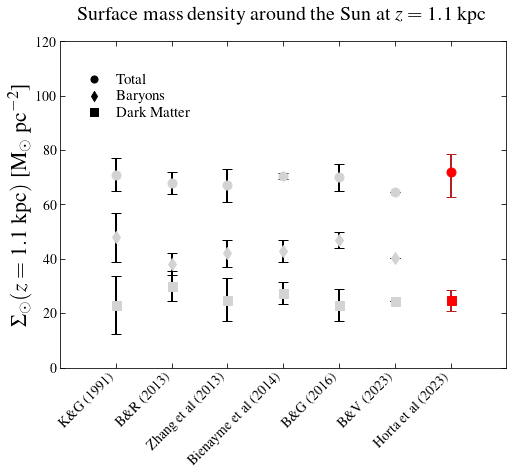

In [78]:
names = ['K$\&$G (1991)','B$\&$R (2013)','Zhang et al (2013)','Bienayme et al (2014)','B$\&$G (2016)','B$\&$V (2023)','Horta et al (2023)']
vals = [71,68,67,70.5,70,64.7,sigma_sun[1]]
err = [6,4,6,1,5,0,(sigma_sun[2]-sigma_sun)/2.]
vals_bary = [48,38,42,43,47,40.2,0]
err_bary = [9,4,5,4,3,0,0]
vals_dm= [23,30,25,27.5,23,24.5,sigma_sun[1]-47]
err_dm_sun_l = np.sqrt(3**2+np.array(sigma_sun[1]-sigma_sun[0]))
err_dm_sun_h = np.sqrt(3**2+np.array(sigma_sun[2]-sigma_sun[1]))
err_dm = [10.8,5.6,7.8,4.1,5.8,0,[err_dm_sun_l,err_dm_sun_h]]

positions = np.linspace(0,7,8)

fig = plt.figure(figsize=(8,6),facecolor='white',rasterized=True)

fig.suptitle('Surface mass density around the Sun at $z=1.1$ kpc',fontsize=20,x=0.51,y=.96)
plt.errorbar(positions[:-2],vals[:-1],yerr=err[:-1],markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='o',color='lightgray')
plt.errorbar(positions[-2],vals[-1],yerr=[[sigma_sun[1]-sigma_sun[0]],[sigma_sun[2]-sigma_sun[1]]],markersize=9,ecolor='firebrick', elinewidth=2, capsize=5,zorder=0,fmt='o',color='r')
plt.errorbar(positions[:-2],vals_bary[:-1],yerr=err_bary[:-1],markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='d',color='lightgray')
plt.errorbar(positions[:-2],vals_dm[:-1],yerr=err_dm[:-1],markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='s',color='lightgray')
plt.errorbar(positions[-2],vals_dm[-1],yerr=[[4.2],[3.6]],markersize=9,ecolor='firebrick', elinewidth=2, capsize=5,zorder=0,fmt='s',color='r')


plt.scatter(positions[0]-0.4,106,c='k',s=50)
plt.scatter(positions[0]-0.4,100,c='k',s=50,marker='d')
plt.scatter(positions[0]-0.4,94,c='k',s=50,marker='s')
plt.text(positions[0],104.4,'Total',color='k',fontsize=15)
plt.text(positions[0],98.4,'Baryons',color='k',fontsize=15)
plt.text(positions[0],92.4,'Dark Matter',color='k',fontsize=15)

plt.ylabel(r'$\Sigma_{\odot} (z=1.1~\mathrm{kpc})$ [M$_{\odot}$ pc$^{-2}$]',fontsize=22)
plt.xticks(positions[:-1], names,fontsize=16)
plt.xticks(rotation=45,ha='right')
plt.ylim(0,120)
plt.xlim(-1,7)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/sigma_Rsun-resubmit.pdf',dpi=500, bbox_inches = 'tight')



In [87]:
print('DM contribution of: '+str(np.array([err_dm_sun_l,sigma_sun[1]-47,err_dm_sun_h])))

DM contribution of: [ 4.24781588 24.87519031  3.98003459]


# Midplane volume mass density

In [79]:
popt-popt_l,popt,popt_h-popt
rho0_sun_l = popt_l[0]
rho0_sun = popt[0]
rho0_sun_h = popt_h[0]
rho0_sun_tot = [rho0_sun_l,rho0_sun,rho0_sun_h]
rho0_sun_tot

[0.07120488145704323, 0.08062740263804777, 0.09610312843199041]

# Compute the value from DM

In [80]:
sigma_sun_bary = [44,47,50] # from McKee et al 2015
rho0_sun_dm = (sigma_sun-sigma_sun_bary)/(2.*1100)
rho0_sun_dm


array([0.00855966, 0.0113069 , 0.01305267])

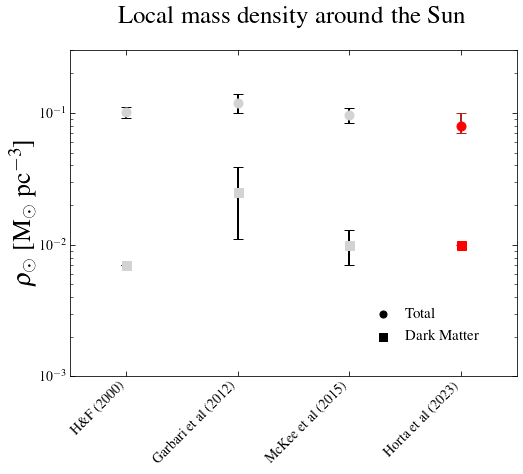

In [81]:
positions = np.linspace(0,3,4)

names_ = [r'H$\&$F (2000)','Garbari et al (2012)','McKee et al (2015)','Horta et al (2023)']

fig = plt.figure(figsize=(8,6),facecolor='white')


fig.suptitle('Local mass density around the Sun',fontsize=25,x=0.51,y=0.98)

plt.errorbar(0,0.102,yerr = 0.01,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='o',color='lightgray')
plt.errorbar(0,0.007,yerr=0,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='s',color='lightgray')
plt.errorbar(1,0.12,yerr = 0.02,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='o',color='lightgray')
plt.errorbar(1,0.025,yerr=0.014,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='s',color='lightgray')
plt.errorbar(2,0.097,yerr = 0.013,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='o',color='lightgray')
plt.errorbar(2,0.01,yerr=0.003,markersize=9,ecolor='k', elinewidth=2, capsize=5,zorder=0,fmt='s',color='lightgray')

plt.errorbar(3,round(rho0_sun_tot[1],2),yerr=[[round(rho0_sun_tot[1],2)-round(rho0_sun_tot[0],2)],[round(rho0_sun_tot[2],2)-round(rho0_sun_tot[1],2)]],markersize=9,ecolor='firebrick', elinewidth=2, capsize=5,zorder=0,fmt='o',color='r')
plt.errorbar(3,round(rho0_sun_dm[1],2),yerr=[[round(rho0_sun_dm[1],2)-round(rho0_sun_dm[0],2)],[round(rho0_sun_dm[2],2)-round(rho0_sun_dm[1],2)]],markersize=9,ecolor='firebrick', elinewidth=2, capsize=5,zorder=0,fmt='s',color='r')

plt.ylabel(r'$\rho_{\odot}$ [M$_{\odot}$ pc$^{-3}$]',fontsize=26)
plt.xticks(np.linspace(0,3,4), names_,fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.001,0.3)
plt.xlim(-0.5,3.5)
plt.scatter(positions[-2]+0.3,0.003,c='k',s=50)
plt.scatter(positions[-2]+0.3,0.002,c='k',s=50,marker='s')
plt.text(positions[-2]+0.5,0.0028,'Total',color='k',fontsize=15)
plt.text(positions[-2]+0.5,0.0019,'Dark Matter',color='k',fontsize=15)


plt.yscale('log')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/rho_midplane-resubmit.pdf',dpi=500, bbox_inches = 'tight')


# compute $z_0$ and $v_{z,0}$

In [82]:
pcls_z0 = []
pcls_vz0 = []

for bdata, res in tqdm.tqdm_notebook(zip(bdatas, reses)):
    tmp_data = bdata.copy()
    tmp_data["label"] = tmp_data.pop("mgfe")
    tmp_data["label_err"] = tmp_data.pop("mgfe_err")
    tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
    tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

    errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
    
    z0_samples = np.random.normal(res.params['pos0'], errs['pos0'][0], size=100)
    vz0_samples = np.random.normal(res.params['vel0'], errs['vel0'][0], size=100)
    
    pcls_z0.append(np.nanpercentile(z0_samples, [5, 16, 50, 84, 95]))
    pcls_vz0.append(np.nanpercentile(vz0_samples, [5, 16, 50, 84, 95]))
    
pcls_z0 = np.array(pcls_z0)
pcls_vz0 = np.array(pcls_vz0)


0it [00:00, ?it/s]

In [83]:
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/pcls-z0-100boots',np.array(pcls_z0))
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/pcls-vz0-100boots',np.array(pcls_vz0))
np.save('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/py/sav/force-law/errs-100boots',np.array(errs))


In [84]:
z0_l = (round(np.mean(pcls_z0[:,1]),4)*1e3)*u.pc
z0_m = (round(np.mean(pcls_z0[:,2]),4)*1e3)*u.pc
z0_h = (round(np.mean(pcls_z0[:,3]),4)*1e3)*u.pc
print('Midplane position' +str(z0_l)+str(z0_m)+str(z0_h))

Midplane position28.5 pc29.5 pc30.5 pc


In [85]:
pcls_vz0_kms = (pcls_vz0*u.kpc/u.Myr).to(u.km/u.s)

vz0_l = (round(np.mean(np.array(pcls_vz0_kms[:,1])),4)+7.4)*u.km/u.s
vz0_m = (round(np.mean(np.array(pcls_vz0_kms[:,2])),4)+7.4)*u.km/u.s
vz0_h = (round(np.mean(np.array(pcls_vz0_kms[:,3])),4)+7.4)*u.km/u.s
print('Midplane velocity: ' +str(vz0_l)+str(vz0_m)+str(vz0_h))


Midplane velocity: 8.5981 km / s8.6594 km / s8.7171 km / s


In [86]:
freq_l = (vz0_l/(z0_l.to(u.km))).to(u.Myr**-1)
freq_m = (vz0_m/(z0_m.to(u.km))).to(u.Myr**-1)
freq_h = (vz0_h/(z0_h.to(u.km))).to(u.Myr**-1)
print(freq_l,freq_m,freq_h)

0.30853970057120667 1 / Myr 0.3002058888812437 1 / Myr 0.2922978430793386 1 / Myr
